In [1]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Urban Drone Demo
## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [2]:
from drone_mdl_urban import Drone

In [3]:
mdl = Drone()

This is the model structure:

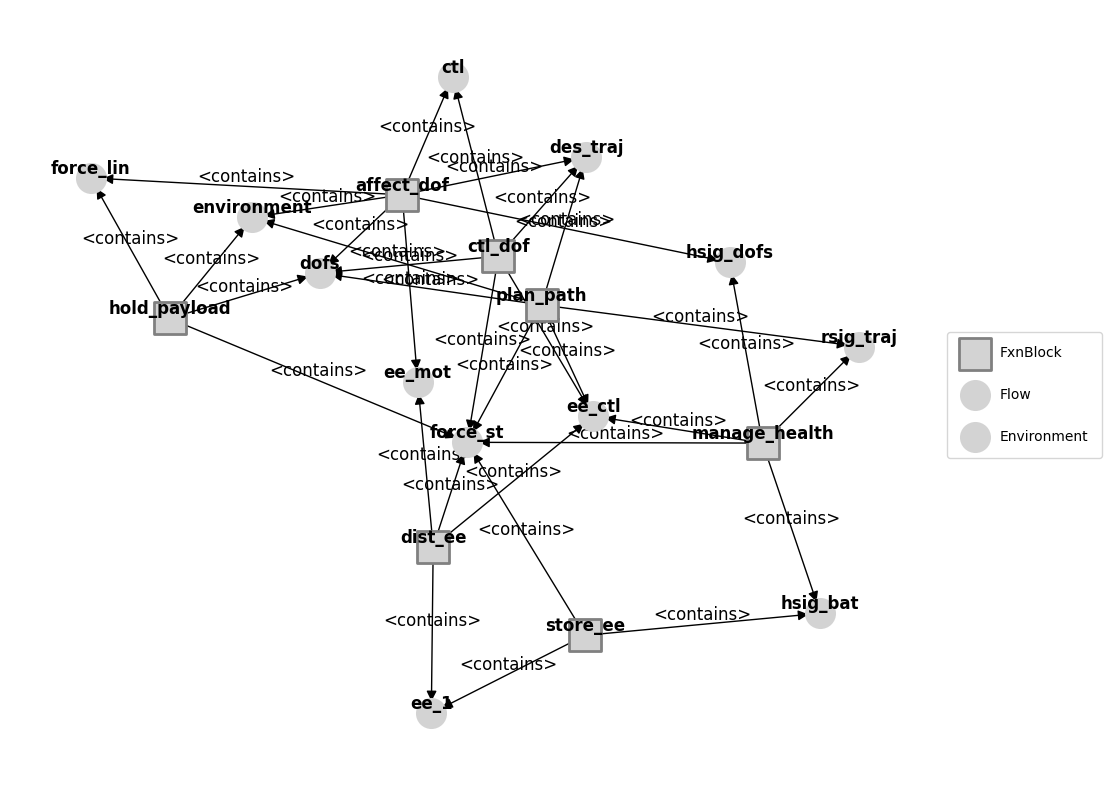

In [4]:
mg = an.graph.ModelGraph(mdl)
fig, ax = mg.draw()

We can also view the grid environment using its `show` methods:

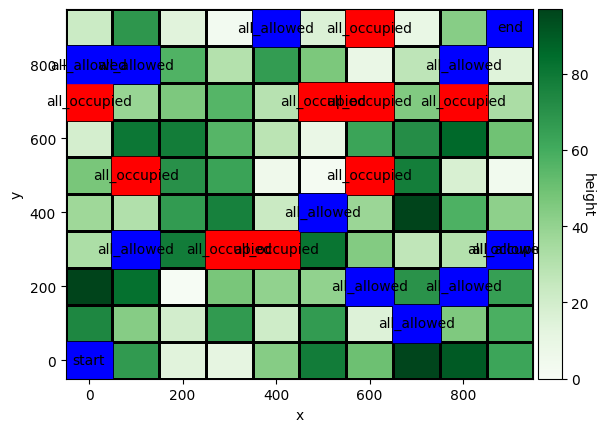

In [5]:
collections={"all_occupied": {"color": "red"}, "all_allowed": {"color": "blue"}, "start": {"color": "blue"}, "end": {"color": "blue"}}
fig, ax = mdl.flows['environment'].c.show("height", collections=collections)

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `show.coord3d`:

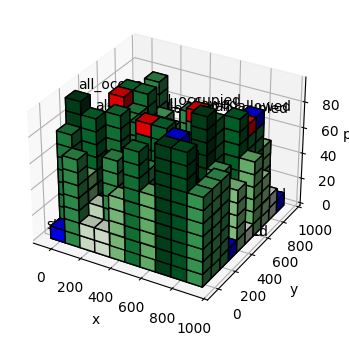

In [6]:
fig, ax = mdl.flows['environment'].c.show_z("height", collections=collections)

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

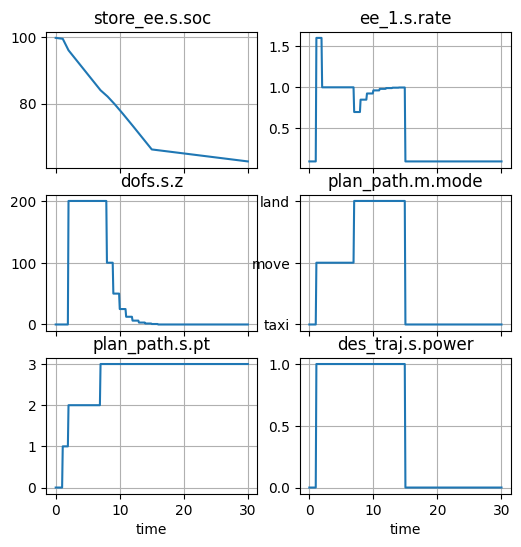

In [7]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = hist_nom.plot_line("store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `History.plot_trajectories`:

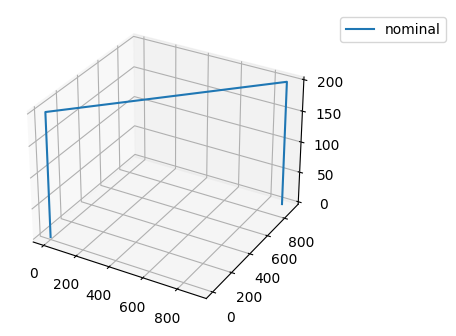

In [8]:
fig, ax = hist_nom.plot_trajectories('dofs.s.x', 'dofs.s.y', 'dofs.s.z')

Trajectory plots can be overlaid on top of environment plots. In this case, we defined the method `plot_env_with_traj` and `plot_env_with_traj_z` for this case.

In [9]:
from drone_mdl_urban import plot_env_with_traj, plot_env_with_traj_z


(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

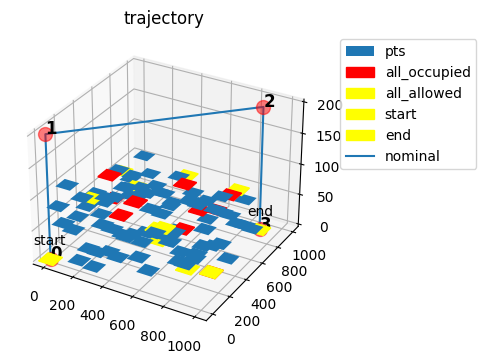

In [10]:
plot_env_with_traj_z(hist_nom, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

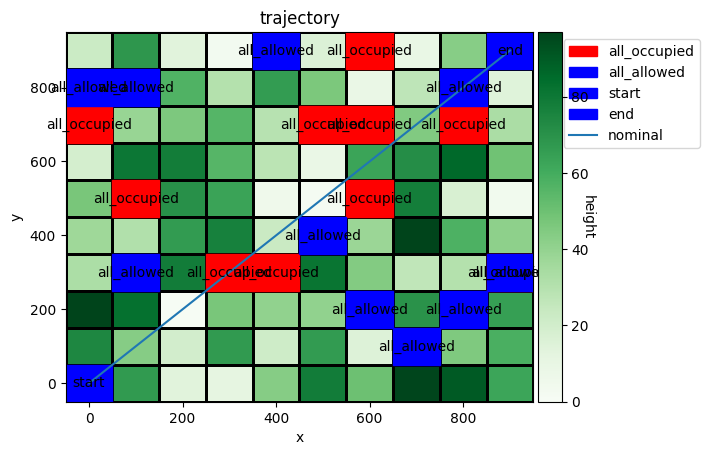

In [11]:
plot_env_with_traj(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [12]:
results_nom

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected_cost:                     0.0
--repcost:                             0
--unsafe_flight_time:                  0
--body_strikes:                      0.0
--head_strikes:                      0.0
--property_restrictions:               0
--safecost:                          0.0
--landcost:                            0
--p_safety:                          0.0
--severities: {'hazardous': 0.0, 'minor': 1.0}

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [13]:
mdl.fxns['affect_dof'].m.faultmodes

{'lf_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_openc': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lf_ctlup': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctldn': Fault(prob=2.0000000000000003e-06, cost=500, phases={}, units='sim'),
 'lf_ctlbreak': Fault(prob=2.0000000000000003e-06, cost=1000, phases={}, units='sim'),
 'lf_mechbreak': Fault(prob=1.0000000000000002e-06, cost=500, phases={}, units='sim'),
 'lf_mechfriction': Fault(prob=5.000000000000001e-07, cost=500, phases={}, units='sim'),
 'lf_propwarp': Fault(prob=1.0000000000000001e-07, cost=200, phases={}, units='sim'),
 'lf_propstuck': Fault(prob=2.0000000000000002e-07, cost=200, phases={}, units='sim'),
 'lf_propbreak': Fault(prob=3.0000000000000004e-07, cost=200, phases={}, units='sim'),
 'lr_short': Fault(prob=1.0000000000000002e-06, cost=200, phases={}, units='sim'),
 'lr_openc': Fault(prob=1.0000000000000002e-06, cost=200, phas

In [14]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

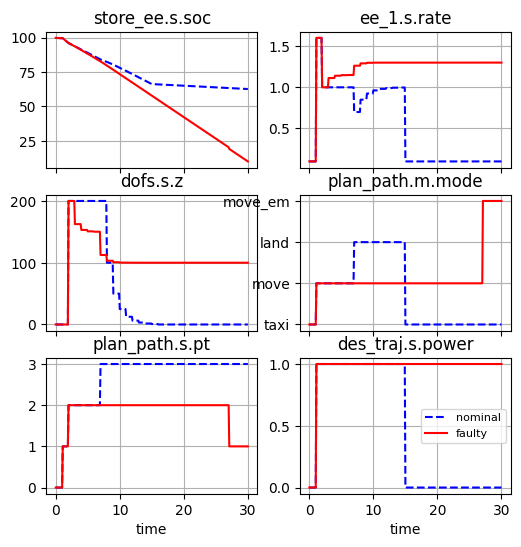

In [15]:
fig, axs = hist_fault.plot_line("store_ee.s.soc",
                                'ee_1.s.rate',
                                'dofs.s.z',
                                'plan_path.m.mode',
                                'plan_path.s.pt',
                                'des_traj.s.power')

(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

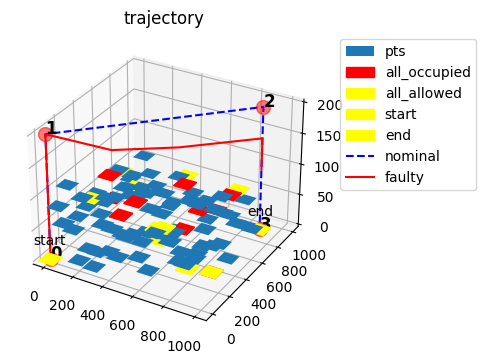

In [16]:
plot_env_with_traj_z(hist_fault, mdl)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'trajectory'}, xlabel='x', ylabel='y'>)

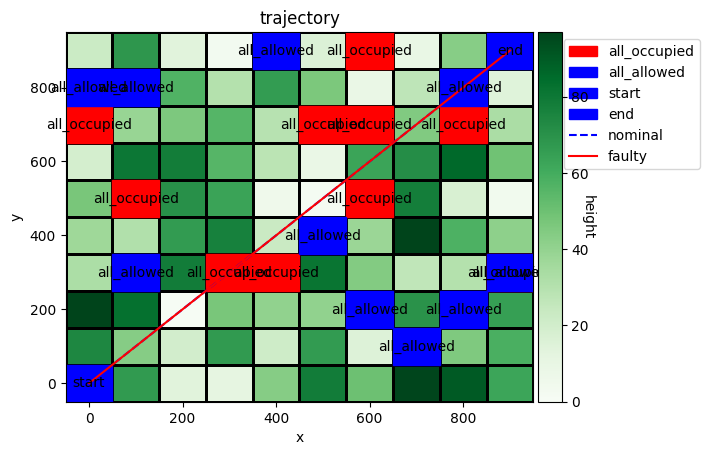

In [17]:
plot_env_with_traj(hist_fault, mdl)

In [18]:
results_fault

endclass.rate:    1.0000000000000002e-06
endclass.cost:                   28700.0
endclass.expected_cost: 2870.0000000000005
endclass.repcost:                    600
endclass.unsafe_flight_time:         281
endclass.body_strikes:               0.0
endclass.head_strikes:               0.0
endclass.property_restrictions:        0
endclass.safecost:               28100.0
endclass.landcost:                     0
endclass.p_safety:                   0.0
endclass.severities: {'hazardous': 0.0, 'minor': 1.0000000000000002e-06}

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [19]:
from fmdtools.analyze.phases import PhaseMap, from_hist
phasemaps = from_hist(hist_nom, fxn_modephases=[])
phasemaps

{'manage_health': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 's1p1': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'store_ee': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'dist_ee': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'lf': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'lr': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'rf': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'rr': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'affect_dof': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'ctl_dof': PhaseMap({'nominal': [0.0, 30.0]}, {}),
 'plan_path': PhaseMap({'taxi': [0.0, 1.0], 'move': [1.1, 6.9], 'land': [7.0, 14.9], 'taxi1': [15.0, 30.0]}, {}),
 'hold_payload': PhaseMap({'nominal': [0.0, 30.0]}, {})}

In [20]:
from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phasemaps['plan_path'].phases['move'])
move_quad

{'samp': 'quadrature',
 'quad': {'nodes': [-0.1724137931034484, 0.8275862068965518],
  'weights': [1.0, 0.92]}}

In [21]:
from fmdtools.sim.sample import FaultDomain, FaultSample


fd = FaultDomain(mdl)
fd.add_all()

fs = FaultSample(fd, phasemap = phasemaps['plan_path'])
fs.add_fault_phases("move", method = "quad",
                    args=(move_quad['quad']['nodes'], move_quad['quad']['weights']))

fs

FaultSample of scenarios: 
 - manage_health_lostfunction_t4
 - manage_health_lostfunction_t7
 - store_ee_nocharge_t4
 - store_ee_nocharge_t7
 - store_ee_lowcharge_t4
 - store_ee_lowcharge_t7
 - store_ee_s1p1_short_t4
 - store_ee_s1p1_short_t7
 - store_ee_s1p1_degr_t4
 - store_ee_s1p1_degr_t7
 - ... (118 total)

In [22]:
endresults, hists = propagate.fault_sample(mdl, fs, staged=False)

SCENARIOS COMPLETE:   0%|          | 0/118 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   1%|          | 1/118 [00:00<00:52,  2.23it/s]

SCENARIOS COMPLETE:   2%|▏         | 2/118 [00:00<00:51,  2.23it/s]

SCENARIOS COMPLETE:   3%|▎         | 3/118 [00:01<00:51,  2.23it/s]

SCENARIOS COMPLETE:   3%|▎         | 4/118 [00:01<00:52,  2.19it/s]

SCENARIOS COMPLETE:   4%|▍         | 5/118 [00:02<00:51,  2.19it/s]

SCENARIOS COMPLETE:   5%|▌         | 6/118 [00:02<00:51,  2.19it/s]

SCENARIOS COMPLETE:   6%|▌         | 7/118 [00:03<00:50,  2.20it/s]

SCENARIOS COMPLETE:   7%|▋         | 8/118 [00:03<00:50,  2.20it/s]

SCENARIOS COMPLETE:   8%|▊         | 9/118 [00:04<00:49,  2.18it/s]

SCENARIOS COMPLETE:   8%|▊         | 10/118 [00:04<00:49,  2.19it/s]

SCENARIOS COMPLETE:   9%|▉         | 11/118 [00:05<00:48,  2.20it/s]

SCENARIOS COMPLETE:  10%|█         | 12/118 [00:05<00:48,  2.20it/s]

SCENARIOS COMPLETE:  11%|█         | 13/118 [00:05<00:48,  2.18it/s]

SCENARIOS COMPLETE:  12%|█▏        | 14/118 [00:06<00:47,  2.19it/s]

SCENARIOS COMPLETE:  13%|█▎        | 15/118 [00:06<00:46,  2.19it/s]

SCENARIOS COMPLETE:  14%|█▎        | 16/118 [00:07<00:46,  2.19it/s]

SCENARIOS COMPLETE:  14%|█▍        | 17/118 [00:07<00:46,  2.19it/s]

SCENARIOS COMPLETE:  15%|█▌        | 18/118 [00:08<00:45,  2.20it/s]

SCENARIOS COMPLETE:  16%|█▌        | 19/118 [00:08<00:44,  2.21it/s]

SCENARIOS COMPLETE:  17%|█▋        | 20/118 [00:09<00:44,  2.19it/s]

SCENARIOS COMPLETE:  18%|█▊        | 21/118 [00:09<00:43,  2.21it/s]

SCENARIOS COMPLETE:  19%|█▊        | 22/118 [00:10<00:43,  2.20it/s]

SCENARIOS COMPLETE:  19%|█▉        | 23/118 [00:10<00:43,  2.21it/s]

SCENARIOS COMPLETE:  20%|██        | 24/118 [00:10<00:42,  2.21it/s]

SCENARIOS COMPLETE:  21%|██        | 25/118 [00:11<00:41,  2.22it/s]

SCENARIOS COMPLETE:  22%|██▏       | 26/118 [00:11<00:41,  2.20it/s]

SCENARIOS COMPLETE:  23%|██▎       | 27/118 [00:12<00:41,  2.20it/s]

SCENARIOS COMPLETE:  24%|██▎       | 28/118 [00:12<00:40,  2.21it/s]

SCENARIOS COMPLETE:  25%|██▍       | 29/118 [00:13<00:40,  2.20it/s]

SCENARIOS COMPLETE:  25%|██▌       | 30/118 [00:13<00:39,  2.21it/s]

SCENARIOS COMPLETE:  26%|██▋       | 31/118 [00:14<00:39,  2.22it/s]

SCENARIOS COMPLETE:  27%|██▋       | 32/118 [00:14<00:38,  2.21it/s]

SCENARIOS COMPLETE:  28%|██▊       | 33/118 [00:14<00:38,  2.21it/s]

SCENARIOS COMPLETE:  29%|██▉       | 34/118 [00:15<00:38,  2.20it/s]

SCENARIOS COMPLETE:  30%|██▉       | 35/118 [00:15<00:37,  2.20it/s]

SCENARIOS COMPLETE:  31%|███       | 36/118 [00:16<00:37,  2.21it/s]

SCENARIOS COMPLETE:  31%|███▏      | 37/118 [00:16<00:36,  2.21it/s]

SCENARIOS COMPLETE:  32%|███▏      | 38/118 [00:17<00:36,  2.19it/s]

SCENARIOS COMPLETE:  33%|███▎      | 39/118 [00:17<00:36,  2.19it/s]

SCENARIOS COMPLETE:  34%|███▍      | 40/118 [00:18<00:35,  2.20it/s]

SCENARIOS COMPLETE:  35%|███▍      | 41/118 [00:18<00:34,  2.21it/s]

SCENARIOS COMPLETE:  36%|███▌      | 42/118 [00:19<00:34,  2.20it/s]

SCENARIOS COMPLETE:  36%|███▋      | 43/118 [00:19<00:33,  2.21it/s]

SCENARIOS COMPLETE:  37%|███▋      | 44/118 [00:19<00:33,  2.21it/s]

SCENARIOS COMPLETE:  38%|███▊      | 45/118 [00:20<00:33,  2.21it/s]

SCENARIOS COMPLETE:  39%|███▉      | 46/118 [00:20<00:32,  2.21it/s]

SCENARIOS COMPLETE:  40%|███▉      | 47/118 [00:21<00:32,  2.19it/s]

SCENARIOS COMPLETE:  41%|████      | 48/118 [00:21<00:32,  2.18it/s]

SCENARIOS COMPLETE:  42%|████▏     | 49/118 [00:22<00:31,  2.20it/s]

SCENARIOS COMPLETE:  42%|████▏     | 50/118 [00:22<00:30,  2.21it/s]

SCENARIOS COMPLETE:  43%|████▎     | 51/118 [00:23<00:30,  2.20it/s]

SCENARIOS COMPLETE:  44%|████▍     | 52/118 [00:23<00:29,  2.21it/s]

SCENARIOS COMPLETE:  45%|████▍     | 53/118 [00:24<00:29,  2.20it/s]

SCENARIOS COMPLETE:  46%|████▌     | 54/118 [00:24<00:29,  2.20it/s]

SCENARIOS COMPLETE:  47%|████▋     | 55/118 [00:24<00:28,  2.20it/s]

SCENARIOS COMPLETE:  47%|████▋     | 56/118 [00:25<00:28,  2.20it/s]

SCENARIOS COMPLETE:  48%|████▊     | 57/118 [00:25<00:27,  2.20it/s]

SCENARIOS COMPLETE:  49%|████▉     | 58/118 [00:26<00:27,  2.20it/s]

SCENARIOS COMPLETE:  50%|█████     | 59/118 [00:26<00:26,  2.20it/s]

SCENARIOS COMPLETE:  51%|█████     | 60/118 [00:27<00:26,  2.19it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 61/118 [00:27<00:25,  2.20it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 62/118 [00:28<00:25,  2.21it/s]

SCENARIOS COMPLETE:  53%|█████▎    | 63/118 [00:28<00:24,  2.22it/s]

SCENARIOS COMPLETE:  54%|█████▍    | 64/118 [00:29<00:24,  2.21it/s]

SCENARIOS COMPLETE:  55%|█████▌    | 65/118 [00:29<00:23,  2.21it/s]

SCENARIOS COMPLETE:  56%|█████▌    | 66/118 [00:29<00:23,  2.21it/s]

SCENARIOS COMPLETE:  57%|█████▋    | 67/118 [00:30<00:23,  2.20it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 68/118 [00:30<00:22,  2.21it/s]

SCENARIOS COMPLETE:  58%|█████▊    | 69/118 [00:31<00:22,  2.21it/s]

SCENARIOS COMPLETE:  59%|█████▉    | 70/118 [00:31<00:21,  2.21it/s]

SCENARIOS COMPLETE:  60%|██████    | 71/118 [00:32<00:21,  2.21it/s]

SCENARIOS COMPLETE:  61%|██████    | 72/118 [00:32<00:20,  2.19it/s]

SCENARIOS COMPLETE:  62%|██████▏   | 73/118 [00:33<00:20,  2.20it/s]

SCENARIOS COMPLETE:  63%|██████▎   | 74/118 [00:33<00:19,  2.20it/s]

SCENARIOS COMPLETE:  64%|██████▎   | 75/118 [00:34<00:19,  2.19it/s]

SCENARIOS COMPLETE:  64%|██████▍   | 76/118 [00:34<00:19,  2.20it/s]

SCENARIOS COMPLETE:  65%|██████▌   | 77/118 [00:34<00:18,  2.18it/s]

SCENARIOS COMPLETE:  66%|██████▌   | 78/118 [00:35<00:18,  2.19it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 79/118 [00:35<00:17,  2.20it/s]

SCENARIOS COMPLETE:  68%|██████▊   | 80/118 [00:36<00:17,  2.20it/s]

SCENARIOS COMPLETE:  69%|██████▊   | 81/118 [00:36<00:16,  2.21it/s]

SCENARIOS COMPLETE:  69%|██████▉   | 82/118 [00:37<00:16,  2.20it/s]

SCENARIOS COMPLETE:  70%|███████   | 83/118 [00:37<00:15,  2.21it/s]

SCENARIOS COMPLETE:  71%|███████   | 84/118 [00:38<00:15,  2.22it/s]

SCENARIOS COMPLETE:  72%|███████▏  | 85/118 [00:38<00:14,  2.21it/s]

SCENARIOS COMPLETE:  73%|███████▎  | 86/118 [00:39<00:14,  2.20it/s]

SCENARIOS COMPLETE:  74%|███████▎  | 87/118 [00:39<00:14,  2.20it/s]

SCENARIOS COMPLETE:  75%|███████▍  | 88/118 [00:39<00:13,  2.20it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 89/118 [00:40<00:13,  2.20it/s]

SCENARIOS COMPLETE:  76%|███████▋  | 90/118 [00:40<00:12,  2.21it/s]

SCENARIOS COMPLETE:  77%|███████▋  | 91/118 [00:41<00:12,  2.20it/s]

SCENARIOS COMPLETE:  78%|███████▊  | 92/118 [00:41<00:11,  2.21it/s]

SCENARIOS COMPLETE:  79%|███████▉  | 93/118 [00:42<00:11,  2.19it/s]

SCENARIOS COMPLETE:  80%|███████▉  | 94/118 [00:42<00:10,  2.20it/s]

SCENARIOS COMPLETE:  81%|████████  | 95/118 [00:43<00:10,  2.20it/s]

SCENARIOS COMPLETE:  81%|████████▏ | 96/118 [00:43<00:10,  2.20it/s]

SCENARIOS COMPLETE:  82%|████████▏ | 97/118 [00:44<00:09,  2.18it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 98/118 [00:44<00:09,  2.20it/s]

SCENARIOS COMPLETE:  84%|████████▍ | 99/118 [00:44<00:08,  2.19it/s]

SCENARIOS COMPLETE:  85%|████████▍ | 100/118 [00:45<00:08,  2.19it/s]

SCENARIOS COMPLETE:  86%|████████▌ | 101/118 [00:45<00:07,  2.19it/s]

SCENARIOS COMPLETE:  86%|████████▋ | 102/118 [00:46<00:07,  2.20it/s]

SCENARIOS COMPLETE:  87%|████████▋ | 103/118 [00:46<00:06,  2.18it/s]

SCENARIOS COMPLETE:  88%|████████▊ | 104/118 [00:47<00:06,  2.18it/s]

SCENARIOS COMPLETE:  89%|████████▉ | 105/118 [00:47<00:05,  2.17it/s]

SCENARIOS COMPLETE:  90%|████████▉ | 106/118 [00:48<00:05,  2.17it/s]

SCENARIOS COMPLETE:  91%|█████████ | 107/118 [00:48<00:05,  2.19it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 108/118 [00:49<00:04,  2.20it/s]

SCENARIOS COMPLETE:  92%|█████████▏| 109/118 [00:49<00:04,  2.20it/s]

SCENARIOS COMPLETE:  93%|█████████▎| 110/118 [00:49<00:03,  2.20it/s]

SCENARIOS COMPLETE:  94%|█████████▍| 111/118 [00:50<00:03,  2.21it/s]

SCENARIOS COMPLETE:  95%|█████████▍| 112/118 [00:50<00:02,  2.20it/s]

SCENARIOS COMPLETE:  96%|█████████▌| 113/118 [00:51<00:02,  2.21it/s]

SCENARIOS COMPLETE:  97%|█████████▋| 114/118 [00:51<00:01,  2.21it/s]

SCENARIOS COMPLETE:  97%|█████████▋| 115/118 [00:52<00:01,  2.22it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 116/118 [00:52<00:00,  2.22it/s]

SCENARIOS COMPLETE:  99%|█████████▉| 117/118 [00:53<00:00,  2.23it/s]

SCENARIOS COMPLETE: 100%|██████████| 118/118 [00:53<00:00,  2.23it/s]

SCENARIOS COMPLETE: 100%|██████████| 118/118 [00:53<00:00,  2.20it/s]

(<Figure size 400x400 with 1 Axes>, <Axes3D: title={'center': 'trajectory'}>)

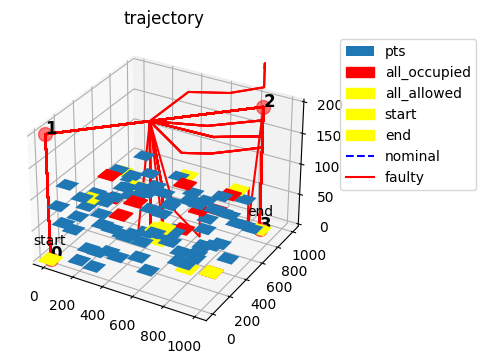

In [23]:
plot_env_with_traj_z(hists , mdl)

In [24]:
statsfmea = an.tabulate.FMEA(endresults, fs,
                            weight_metrics=['rate'],
                            avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                         'landcost', 'body_strikes',
                                         'head_strikes', 'property_restrictions'])
fmeatab = statsfmea.as_table(sort_by="cost")
fmeatab

rate  unsafe_flight_time  \
plan_path     vision_lack_of_detection    5.666667e-02               246.0   
              vision_undesired_detection  5.666667e-02               110.5   
dist_ee       degr                        5.000000e-06               246.0   
              short                       3.000000e-06               246.0   
affect_dof    rf_ctlbreak                 2.000000e-06               246.0   
              lf_ctlbreak                 2.000000e-06               246.0   
dist_ee       break                       2.000000e-06               246.0   
affect_dof    lr_ctlbreak                 2.000000e-06               246.0   
              rr_ctlbreak                 2.000000e-06               246.0   
              lf_ctlup                    2.000000e-06               246.0   
              rf_ctlup                    2.000000e-06               246.0   
              rr_short                    1.000000e-06               246.0   
              lf_openc                    1.000000e-06               246.0   
              rf_openc                    1.000000e-06               246.0   
              lf_mechbreak                1.000000e-06               246.0   
              lf_short                    1.000000e-06               246.0   
              rf_short                    1.000000e-06               246.0   
              rf_mechbreak                1.000000e-06               246.0   
              lr_short                    1.000000e-06               246.0   
store_ee      s1p1_short                  6.800000e-07               246.0   
              s1p1_degr                   6.800000e-07               246.0   
              s1p1_break                  6.800000e-07               246.0   
              lowcharge                   1.586667e-06               246.0   
              nocharge                    4.533333e-07               246.0   
affect_dof    lf_ctldn                    2.000000e-06               246.0   
              lr_ctlup                    2.000000e-06               246.0   
              rf_ctldn                    2.000000e-06               246.0   
              rr_ctldn                    2.000000e-06               246.0   
              lr_ctldn                    2.000000e-06               246.0   
              rr_ctlup                    2.000000e-06               246.0   
              lf_propbreak                3.000000e-07               246.0   
              rf_propbreak                3.000000e-07               246.0   
              rr_mechbreak                1.000000e-06               246.0   
              lr_mechbreak                1.000000e-06               246.0   
plan_path     degloc                      2.720000e-07               246.0   
ctl_dof       degctl                      2.720000e-07               246.0   
affect_dof    rf_propstuck                2.000000e-07               246.0   
              lf_propstuck                2.000000e-07               246.0   
plan_path     noloc                       6.800000e-08               246.0   
ctl_dof       noctl                       6.800000e-08               246.0   
hold_payload  deform                      2.720000e-08               246.0   
              break                       6.800000e-09               246.0   
affect_dof    rr_openc                    1.000000e-06               246.0   
              lr_openc                    1.000000e-06               246.0   
              lr_propbreak                3.000000e-07               246.0   
              rr_propbreak                3.000000e-07               246.0   
              lr_propstuck                2.000000e-07               246.0   
              rr_propstuck                2.000000e-07               246.0   
manage_health lostfunction                1.700000e-09               246.0   
store_ee      s1p1_nocharge               1.360000e-06               246.0   
affect_dof    rr_mechfriction             5.000000e-07               246